In [1]:
### Implement REINFORCE (Monte Carlo Policy Gradients) to solve LunarLander task in OpenAI-gym

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

import torch
# torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical #bernoulli distribution

import time #human agent

In [3]:
env_id = 'LunarLander-v2'
env = gym.make(env_id)
# env.seed(0)

In [4]:
env.observation_space

Box(8,)

In [5]:
env.action_space

Discrete(4)

In [6]:
## check for bounds
env.observation_space.is_bounded()

False

In [7]:
LEARNING_RATE = 0.5*1e-2 #set learning rate

## Define Policy

In [8]:
class Policy(nn.Module):
    """Defines the general policy for an agent following simple NN architecture"""
    def __init__(self, state_size, action_size, h1=16):
        """Creates the model using a 3 Hidden layer NN"""
        super(Policy, self).__init__()#inherit methods from parent class & override forward f(x)
        self.fc1 = nn.Linear(in_features=state_size, out_features=h1)
        self.fc2 = nn.Linear(in_features=h1, out_features=action_size)
    def forward(self, x):
        """
        Performs one-pass from state -> action mapping.
        @Param:
        1. x - input state
        @return:
        x - action as a set of vector following stochastic measure. softmax output to logits from NN.
        """
        if(type(x) != torch.Tensor):
            try:
                x = torch.from_numpy(x).float().unsqueeze(0)#convert ndarray to torch.Tensor object
            except:
                raise TypeError(f"expected type torch.Tensor. got {type(x)}")
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    def act(self, state):
        """
        Uses current deterministic policy to determine the set of action to perform
        @param:
        1. state: input state of env. shape = env.observation_space.shape[0]
        @return:
        - action: (int) discrete action to take by the agent.
        - log_probs: (array_like) log of output from softmax unit. set of log probabilities.
        """
        probs = self.forward(state).cpu() #get estimated action following stochastic measure
        m = Categorical(probs)#get Bernoulli distribution of action
        action = m.sample() #returns the action based on the probability of each based on Benoulli(probs)
        return action.item(), m.log_prob(action)

In [9]:
policy = Policy(env.observation_space.shape[0], env.action_space.n)

In [10]:
optimizer = optim.Adam(params=policy.parameters(), lr=LEARNING_RATE)

### Train using REINFORCE

In [11]:
def reinforce(num_episode=20000, max_tau=1000, gamma=1.0, print_every=100):
    """
    Implements the Reinforce algorithm.
    See paper for more details: https://bit.ly/REINFORCE_paper
    @param:
    1. num_episode: number of epochs to train for.
    2. max_tau: length of trajectory, 𝝉.
    3. gamma: discounted return, γ.
    4. print_every: pprint details after very X epochs.
    @return:
    - scores: (array_like) expected return over epochs.
    """
    scores_deque = deque(maxlen=100)# ∑R for last N=100 episodes
    scores = []
    for i_episode in range(1, num_episode + 1):
        saved_log_probs = []
        rewards = []
        state = env.reset()#reset the environment at the start of each episode
        for t in range(max_tau):#iterate through trajectory
            action, log_probs = policy.act(state)
            state, reward, done,_ = env.step(action)
            rewards.append(reward)
            saved_log_probs.append(log_probs)
            if(done):
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        #calculate Reward with gamma in account
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([g*r for g,r in zip(discounts, rewards)])#R = sum(γ^0*reward_0 + γ^1*reward_1 + γ^n*reward_n)

        ### Implement Stochastic Gradient Ascent
        policy_loss = []#estimated loss of the Policy (should be maximized towards optimal policy, see Hill climb)
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob*R)#-ve takes in account for gradient ascent
        
        policy_loss = torch.cat(policy_loss).sum() #find total loss, U(Θ)
        
        optimizer.zero_grad()#clear gradients
        policy_loss.backward()#performs back-prop
        optimizer.step()#performs a single update
    
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=200.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
    return scores

In [12]:
scores = reinforce()

Episode 100	Average Score: -173.72
Episode 200	Average Score: -194.32
Episode 300	Average Score: -142.07
Episode 400	Average Score: -140.14
Episode 500	Average Score: -130.31
Episode 600	Average Score: -115.80
Episode 700	Average Score: -118.76
Episode 800	Average Score: -110.89
Episode 900	Average Score: -105.05
Episode 1000	Average Score: -100.01
Episode 1100	Average Score: -102.30
Episode 1200	Average Score: -110.36
Episode 1300	Average Score: -98.86
Episode 1400	Average Score: -95.65
Episode 1500	Average Score: -85.86
Episode 1600	Average Score: -87.90
Episode 1700	Average Score: -57.28
Episode 1800	Average Score: -46.50
Episode 1900	Average Score: -36.16
Episode 2000	Average Score: -23.74
Episode 2100	Average Score: -16.01
Episode 2200	Average Score: -14.32
Episode 2300	Average Score: -16.56
Episode 2400	Average Score: -13.89
Episode 2500	Average Score: -10.39
Episode 2600	Average Score: -13.96
Episode 2700	Average Score: 9.20
Episode 2800	Average Score: 9.02
Episode 2900	Average 

# Solved Environment in 5299 Episodes!

#### Construct plot with moving averages

In [47]:
import pandas as pd

In [48]:
df = pd.DataFrame(scores)

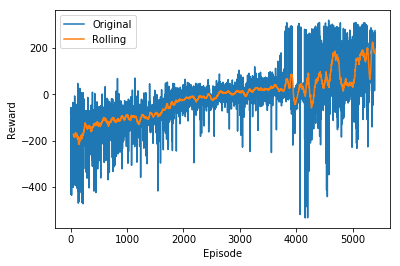

In [65]:
plt.plot(df, label="Original")
plt.plot(df.rolling(window=50).mean(), label="Rolling")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

In [22]:
reward_arr = []
for i in range(3):
    total_reward = 0
    state = env.reset()
    while True:
        action, _ = policy.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            reward_arr.append(total_reward)
            break 

In [23]:
np.mean(reward_arr)

221.92539369151498

### Save the model weights

In [34]:
torch.save(policy.state_dict(), "model.pth")

In [12]:
load_weights = torch.load("model.pth")

In [13]:
policy.load_state_dict(load_weights)

<All keys matched successfully>